In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Used device: {DEVICE}")

%matplotlib inline

Used device: cuda


In [12]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.to(DEVICE)

/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

<class 'numpy.ndarray'>
(966, 644, 3)


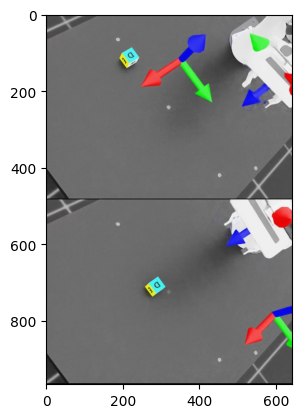

In [13]:
root = "../data/"
img_path = "../data/img.jpg"
img_pil = Image.open(img_path)
img = np.asarray(img_pil)
print(type(img))
print(img.shape)
plt.imshow(img)

query_img_paths = [
    os.path.join(root, "query_img1.jpg"),
    os.path.join(root, "query_img2.jpg"),
    os.path.join(root, "query_img3.jpg"),
]

query_imgs_pil = [ Image.open(img_path) for img_path in query_img_paths ]
query_imgs = [ np.asarray(img) for img in query_imgs_pil ]

In [14]:
# zero-shot (with text): [num_images, num_queries_per_img]
text_queries = [["box", "cube", "square"],]
inputs = processor(text=text_queries, images=img_pil, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs.keys(), end="\n\n\n")


for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])


logits: shape of torch.Size([1, 576, 3])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 3, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([3, 16, 512])
pooler_output: shape of torch.Size([3, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [15]:
from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
print(f"model.config.vision_config.image_size: {model.config.vision_config.image_size}")
image = mixin.resize(img_pil, image_size)
print(f"resized img: {image.size}")
# norm in [0, 1]
input_image = np.asarray(image).astype(np.float32) / 255.0
print(f"{input_image.mean()} +- {input_image.std()}, [{input_image.min()}, {input_image.max()}]")

# Threshold to eliminate low probability predictions
score_threshold = 0.1 # score

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)

scores = torch.sigmoid(logits.values).cpu().detach().numpy()
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

model.config.vision_config.image_size: 768
resized img: (768, 768)
0.4408273696899414 +- 0.14955319464206696, [0.0, 1.0]


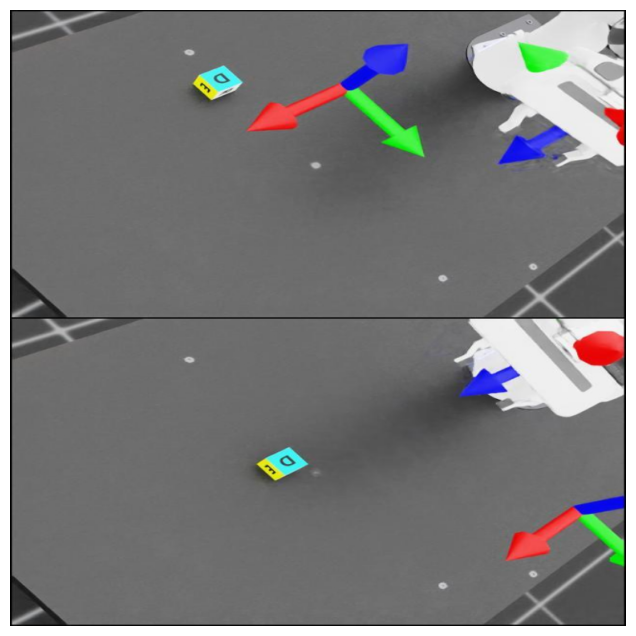

In [16]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot(
          [cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
          [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], 
          "r"
        )
      
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
    
plot_predictions(input_image, text_queries, scores, boxes, labels)

In [26]:
# one-shot (or n-shot) conditioning on image/s
# Process input and query image
inputs = processor(images=image, query_images=query_imgs_pil[0], return_tensors="pt",).to(DEVICE)
for key, val in inputs.items():
    print(f"{key}: {val.shape}")
    
print("")

with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)

    for k, val in outputs.items():
        if k not in {"text_model_output", "vision_model_output"}:
            print(f"{k}: shape of {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])


(966, 644, 3)


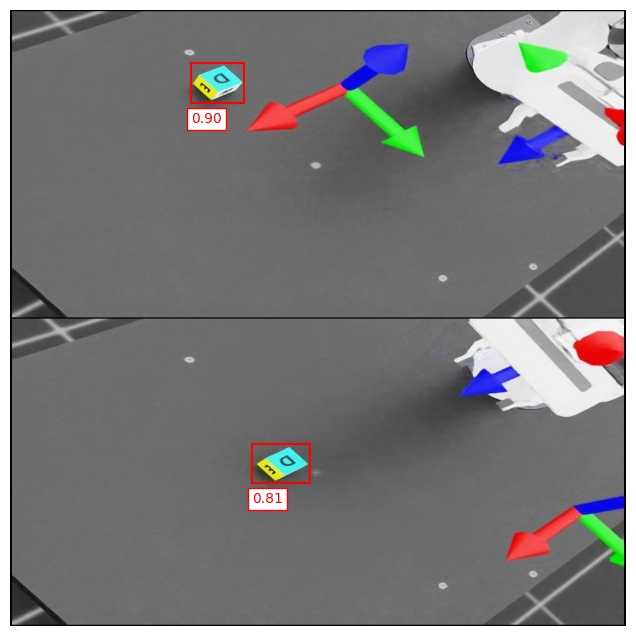

In [33]:
# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)

scores = torch.sigmoid(logits.values).cpu().detach().numpy()
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["target_pred_boxes"][0].cpu().detach().numpy()

score_threshold = 0.8

def plot_boxes(input_image, scores, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box in zip(scores, boxes):
        if score < score_threshold:
            continue

        cx, cy, w, h = box
        ax.plot(
            [cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
            [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], 
            "r"
        )

        ax.text(
            cx - w / 2,
            cy + h / 2 + 0.015,
            f"{score:1.2f}",
            ha="left",
            va="top",
            color="red",
            bbox={
                "facecolor": "white",
                "edgecolor": "red",
                "boxstyle": "square,pad=.3"
            }
        )

# Draw predicted bounding boxes
print(img.shape)
plot_boxes(img, scores, boxes)